# Constrained Single Image Reconstruction



based on https://pytorch3d.org/tutorials/fit_textured_volume

## 0. Install and Import modules
Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...


In [2]:
import os
import sys
import torch
from IPython.display import clear_output
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


clear_output()

In [3]:
from IPython.display import clear_output
!conda install -c conda-forge python-kaleido
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install trimesh
!pip install -U kaleido
# !pip3 install mesh-to-sdf

# !pip install trimesh

clear_output()

In [4]:
import os
import sys
import time
import json
import glob
import torch
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    VolumeRenderer,
    NDCMultinomialRaysampler,
    EmissionAbsorptionRaymarcher
)
from pytorch3d.transforms import so3_exp_map

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")



In [110]:
# @title FEA imports

from IPython.display import clear_output

# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
# from plot_image_grid import image_grid
# from generate_cow_renders import generate_cow_renders
!wget -O constrained_ai.zip https://www.dropbox.com/sh/qkqnreiw6fjtxy0/AAA9N8oEp1tYFvYLf0_FMJ3Oa?dl=0
!unzip -o -d constrained_ai constrained_ai.zip

from constrained_ai.pytorch3DLibs.generate_obj_renders import generate_obj_renders
from constrained_ai.pytorch3DLibs.plot_image_grid import image_grid

clear_output()

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import numpy as np
import matplotlib.pyplot as plt

import numpy as np


import kaleido
import trimesh
import skimage
# from mesh_to_sdf import mesh_to_voxels
clear_output()
import constrained_ai.examples
import constrained_ai.Mesher
import constrained_ai.material
import constrained_ai.plotUtil
import constrained_ai.FE_Solver
import constrained_ai.network
import constrained_ai.projections

from constrained_ai.examples import getExampleBC3D
from constrained_ai.Mesher import RectangularGridMesher3D
from constrained_ai.material import Material
from constrained_ai.FE_Solver import FESolver
from constrained_ai.network import TopNet
from constrained_ai.projections import *
import configparser

import importlib
importlib.reload(constrained_ai.examples)
importlib.reload(constrained_ai.Mesher)
importlib.reload(constrained_ai.material)
importlib.reload(constrained_ai.plotUtil)
importlib.reload(constrained_ai.FE_Solver)
importlib.reload(constrained_ai.network)
importlib.reload(constrained_ai.projections)
from constrained_ai.examples import getExampleBC3D
from constrained_ai.Mesher import RectangularGridMesher3D
from constrained_ai.material import Material
from constrained_ai.plotUtil import plotDisplacement , plotFieldOnMesh
from constrained_ai.FE_Solver import FESolver
from constrained_ai.network import TopNet
from constrained_ai.projections import *

## 1. Generate images of the scene and masks



The following cell generates the training data.
It renders the obj mesh from several viewpoints and returns:
1. A batch of image and silhouette tensors that are produced by the obj mesh renderer.
2. A set of cameras corresponding to each render.

In [6]:
target_cameras, target_images, target_silhouettes = generate_obj_renders(num_views=10,data_dir="./constrained_ai/data/",objName="t1")
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

Generated 10 images/silhouettes/cameras.


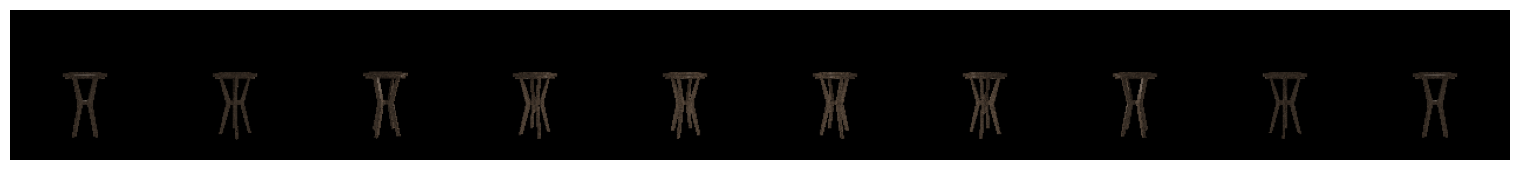

In [7]:
image_grid(target_images.clamp(0., 1.).cpu().numpy(), rows=1, cols=10, rgb=True, fill=True)
plt.show()

## 2. Initialize the volumetric renderer



The following initializes a volumetric renderer that emits a ray from each pixel of a target image and samples a set of uniformly-spaced points along the ray. At each ray-point, the corresponding density and color value is obtained by querying the corresponding location in the volumetric model of the scene (the model is described & instantiated in a later cell).

The renderer is composed of a *raymarcher* and a *raysampler*.
- The *raysampler* is responsible for emitting rays from image pixels and sampling the points along them. Here, we use the `NDCMultinomialRaysampler` which follows the standard PyTorch3D coordinate grid convention (+X from right to left; +Y from bottom to top; +Z away from the user).
- The *raymarcher* takes the densities and colors sampled along each ray and renders each ray into a color and an opacity value of the ray's source pixel. Here we use the `EmissionAbsorptionRaymarcher` which implements the standard Emission-Absorption raymarching algorithm.

In [9]:
# render_size describes the size of both sides of the
# rendered images in pixels. We set this to the same size
# as the target images. I.e. we render at the same
# size as the ground truth images.
render_size = target_images.shape[1]

# Our rendered scene is centered around (0,0,0)
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 6

# 1) Instantiate the raysampler.
# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
# Since we use a volume of size 128^3, we sample n_pts_per_ray=150,
# which roughly corresponds to a one ray-point per voxel.
# We further set the min_depth=0.1 since there is no surface within
# 0.1 units of any camera plane.
raysampler = NDCMultinomialRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=150,
    min_depth=0.1,
    max_depth=volume_extent_world,
)


# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher
# which marches along each ray in order to render
# each ray into a single 3D color vector
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the volumetric render
# with the raysampler and raymarcher objects.
renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher,
)

## 3. Initialize the volumetric model



Next we instantiate a volumetric model of the scene. This quantizes the 3D space to cubical voxels, where each voxel is described with a 3D vector representing the voxel's RGB color and a density scalar which describes the opacity of the voxel (ranging between [0-1], the higher the more opaque).

In order to ensure the range of densities and colors is between [0-1], we represent both volume colors and densities in the logarithmic space. During the forward function of the model, the log-space values are passed through the sigmoid function to bring the log-space values to the correct range.

Additionally, `VolumeModel` contains the renderer object. This object stays unaltered throughout the optimization.

In this cell we also define the `huber` loss function which computes the discrepancy between the rendered colors and masks.

In [69]:
class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size=[64] * 3, voxel_size=0.1):
        super().__init__()
        # After evaluating torch.sigmoid(self.log_colors), we get
        # densities close to zero.
        self.log_densities = torch.nn.Parameter(-4.0 * torch.ones(1, *volume_size))
        # After evaluating torch.sigmoid(self.log_colors), we get
        # a neutral gray color everywhere.
        self.log_colors = torch.nn.Parameter(torch.zeros(3, *volume_size))
        self._voxel_size = voxel_size
        # Store the renderer module as well.
        self._renderer = renderer

    def forward(self, cameras):
        batch_size = cameras.R.shape[0]

        # Convert the log-space values to the densities/colors
        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)

        # Instantiate the Volumes object, making sure
        # the densities and colors are correctly
        # expanded batch_size-times.
        volumes = Volumes(
            densities = densities[None].expand(
                batch_size, *self.log_densities.shape),
            features = colors[None].expand(
                batch_size, *self.log_colors.shape),
            voxel_size=self._voxel_size,
        )

        # Given cameras and volumes, run the renderer
        # and return only the first output value
        # (the 2nd output is a representation of the sampled
        # rays which can be omitted for our purpose).
        return self._renderer(cameras=cameras, volumes=volumes)[0]

# A helper function for evaluating the smooth L1 (huber) loss
# between the rendered silhouettes and colors.
def huber(x, y, scaling=0.1):
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

## 4. Initialize FEA Model

In [130]:
#%% Mesh and BC
ndim = 3
nelx = 10
nely = 14
nelz = 10
exampleNumber=4
exampleNumber=1
elemSize = np.array([1.0,1.0,1.0]).astype(float)
exampleName, bcSettings, symMap = getExampleBC3D(exampleNumber, nelx, nely, nelz)
mesh = RectangularGridMesher3D(ndim, nelx, nely, nelz, elemSize, bcSettings)

desiredVolumeFraction=0.4


#%% Material
E, nu =  1.0, 0.3
matProp = {'physics':'structural', 'Emax':E, 'nu':nu, 'Emin':1e-3*E}
material = Material(matProp)

FEA = FESolver(mesh, material,device)


nnSettings = {'numLayers': 2,\
              'numNeuronsPerLyr':20,\
              'outputDim':1}

fourierMap = {'isOn':True,\
              'minRadius':4, \
              'maxRadius':200,\
              'numTerms':100}

fourierMap['map'] = computeFourierMap(FEA.mesh, fourierMap).to(device);

if(fourierMap['isOn']):
  nnSettings['inputDim'] = 2*fourierMap['numTerms']
else:
  nnSettings['inputDim'] = FEA.mesh.meshSpec['elemSize']
xy = FEA.mesh.generatePoints()
xy = torch.tensor(xy, requires_grad = True).\
                                float().view(-1,3).to(device);
topNet = TopNet(nnSettings).to(device)

def getVolumeChair(volume_model,scale=False):
  densities = torch.sigmoid(volume_model.log_densities)
  # colors = torch.sigmoid(volume_model.log_colors).cpu().detach().numpy()

  if scale:
    densities=densities.unsqueeze(axis=0)
    scaleDown=2
    down=torch.nn.Upsample(size=(densities.shape[2]//scaleDown,
                                      densities.shape[3]//scaleDown,
                                      densities.shape[4]//scaleDown))
    densities=down(densities)
    densities=densities.squeeze(axis=0)

  r=10
  minn=densities.shape[1]//2-r
  maxx=densities.shape[1]//2+r
  r1=5
  minn1=densities.shape[1]//2-r1
  maxx1=densities.shape[1]//2+r1
  # D=densities[0,minn1:maxx1,minn:maxx,minn1:maxx1]
  D=densities[0,minn1:maxx1,21:35,minn1:maxx1]
  D=torch.transpose(torch.transpose(D, 0, 2),1,2)

  return D

def evaluateFEA(FEA,volume_model,J0,scale=False,penal=2.0):

  D=getVolumeChair(volume_model,scale=False)


  J=FEA.objectivePytorch(D.reshape(-1),penal)
  vol=torch.mean(D)
  volcons = (vol/desiredVolumeFraction)- 1.

  return J/J0 +volcons**2, J, vol



In [131]:
# @title dummy example only FEA and fit densities

def evaluateFEA1(FEA,voxel_model,J0,penal=2.0):
  # densities = torch.sigmoid(voxel_model.log_densities)
  densities = voxel_model()
  D=densities[0,:,:,:]


  D=torch.transpose(torch.transpose(D, 0, 2),1,2)

  J=FEA.objectivePytorch(D.reshape(-1),penal)
  vol=torch.mean(D)
  volcons = (vol/desiredVolumeFraction)- 1.

  return J/J0 +volcons**2, J, vol

class VoxelModel(torch.nn.Module):
    def __init__(self, nelx,nely,nelz,vol=desiredVolumeFraction):
        super().__init__()
        # After evaluating torch.sigmoid(self.log_colors), we get
        # densities close to zero.
        self.log_densities = torch.nn.Parameter(vol * torch.ones(1, nelx,nely,nelz))
        self.densities = torch.sigmoid(self.log_densities)

    def forward(self):

        # Convert the log-space values to the densities/colors
        self.densities = self.log_densities

        return self.densities

class VoxelModelNeuralImplicit(torch.nn.Module):
    def __init__(self, nelx,nely,nelz,xy,fourierMap,topNet):
        super().__init__()
        # After evaluating torch.sigmoid(self.log_colors), we get
        # densities close to zero.
        self.xy=xy
        self.fourierMap=fourierMap
        self.topNet=topNet
        self.nelx=nelx
        self.nely=nely
        self.nelz=nelz

        if(fourierMap['isOn']):
          self.xyF = applyFourierMap(self.xy, self.fourierMap)
        else:
          self.xyF =self.xy
        rho = self.topNet(self.xyF)
        self.densities = rho.reshape(1, nelx,nely,nelz)
        # self.log_densities = torch.nn.Parameter(vol * torch.ones(1, nelx,nely,nelz))
        # self.densities = torch.sigmoid(self.log_densities)

    def forward(self):

        if(fourierMap['isOn']):
          self.xyF = applyFourierMap(self.xy, self.fourierMap)
        else:
          self.xyF =self.xy

        rho = self.topNet(self.xyF)

        # Convert the log-space values to the densities/colors
        # self.densities = self.log_densities
        self.densities = rho.reshape(1, self.nelx,self.nely,self.nelz)

        return self.densities


neuralImplicit=True

if neuralImplicit:
  ######VoxelModelNeuralImplicit
  voxel_model = VoxelModelNeuralImplicit(
      nelx,nely,nelz,xy,fourierMap,topNet
  ).to(device)

  # Instantiate the Adam optimizer. We set its master learning rate to 0.1.
  lr = 0.1
  optimizer = torch.optim.Adam(voxel_model.topNet.parameters(), lr=lr)
else:
  voxel_model = VoxelModel(
      # nelz,nelx,nely
      nelx,nely,nelz
  ).to(device)

  # Instantiate the Adam optimizer. We set its master learning rate to 0.1.
  lr = 0.1
  optimizer = torch.optim.Adam(voxel_model.parameters(), lr=lr)


J0=1.0
FEA_err, J, vol=evaluateFEA1(FEA,voxel_model,J0)
J0=J.item()
# We do 300 Adam iterations and sample 10 random images in each minibatch.
batch_size = 10
n_iter = 500



for iteration in range(n_iter):

    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        if neuralImplicit:
          optimizer = torch.optim.Adam(
            voxel_model.topNet.parameters(), lr=lr * 0.1
          )
        else:
          optimizer = torch.optim.Adam(
              voxel_model.parameters(), lr=lr * 0.1
          )


    # Zero the optimizer gradient.
    optimizer.zero_grad()

    penal = min(8.0, 1. + iteration*0.02)

    FEA_err, J, vol=evaluateFEA1(FEA,voxel_model,J0,penal)

    # The optimization loss is a simple
    loss = FEA_err

    # Print the current values of the losses.
    if iteration % 5 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' FEA_err = {float(FEA_err):1.2e}'
            + f' J = {float(J):1.2e}'
            + f' vol = {float(vol):1.2e}'
        )

    if iteration%50==0:
      J0=J.item()

    # Take the optimization step.
    loss.backward()
    optimizer.step()


Iteration 00000: FEA_err = 6.95e-01 J = 1.93e+00 vol = 5.41e-01
Iteration 00005: FEA_err = 1.00e+00 J = 1.44e+00 vol = 6.03e-01
Iteration 00010: FEA_err = 9.20e-01 J = 1.70e+00 vol = 4.77e-01
Iteration 00015: FEA_err = 9.05e-01 J = 1.59e+00 vol = 5.12e-01
Iteration 00020: FEA_err = 9.04e-01 J = 1.54e+00 vol = 5.31e-01
Iteration 00025: FEA_err = 8.95e-01 J = 1.57e+00 vol = 5.15e-01
Iteration 00030: FEA_err = 8.90e-01 J = 1.53e+00 vol = 5.24e-01
Iteration 00035: FEA_err = 8.82e-01 J = 1.53e+00 vol = 5.18e-01
Iteration 00040: FEA_err = 8.71e-01 J = 1.51e+00 vol = 5.18e-01
Iteration 00045: FEA_err = 8.60e-01 J = 1.51e+00 vol = 5.11e-01
Iteration 00050: FEA_err = 8.51e-01 J = 1.50e+00 vol = 5.08e-01
Iteration 00055: FEA_err = 1.06e+00 J = 1.45e+00 vol = 5.24e-01
Iteration 00060: FEA_err = 1.05e+00 J = 1.43e+00 vol = 5.25e-01
Iteration 00065: FEA_err = 1.05e+00 J = 1.43e+00 vol = 5.24e-01
Iteration 00070: FEA_err = 1.04e+00 J = 1.42e+00 vol = 5.22e-01
Iteration 00075: FEA_err = 1.04e+00 J = 

In [135]:
rho.shape

torch.Size([11200])

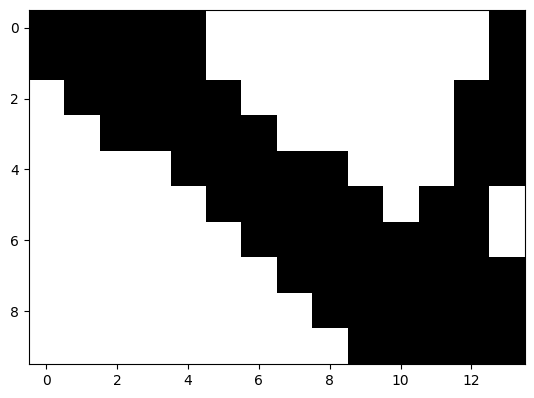

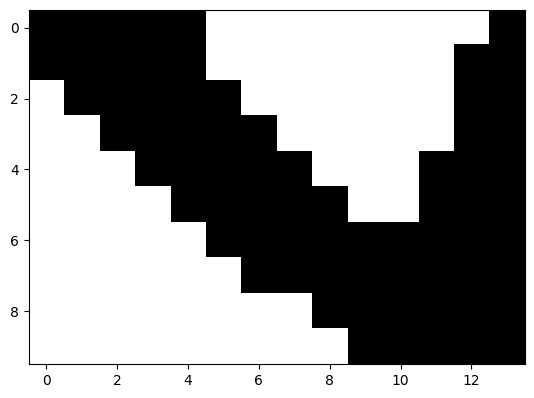

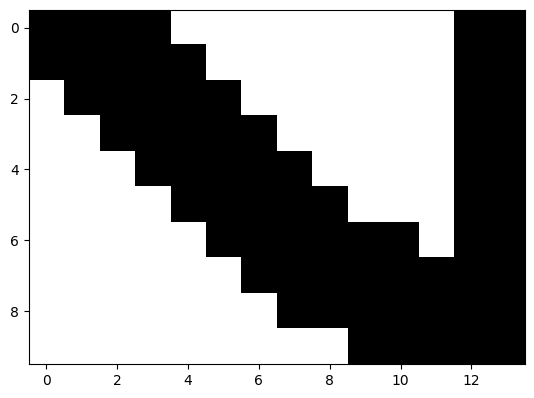

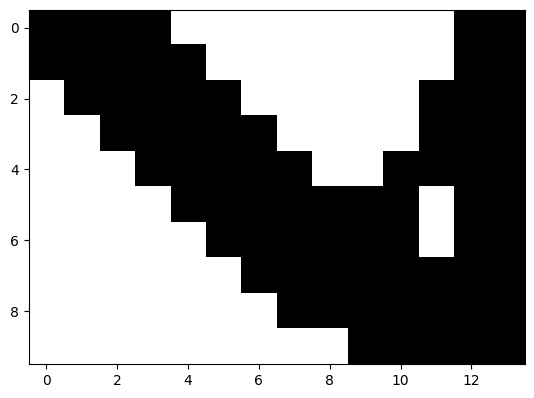

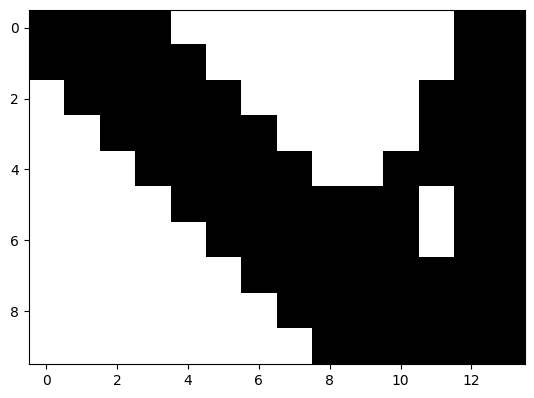

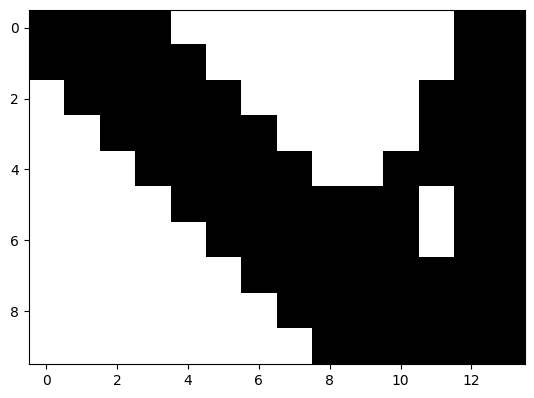

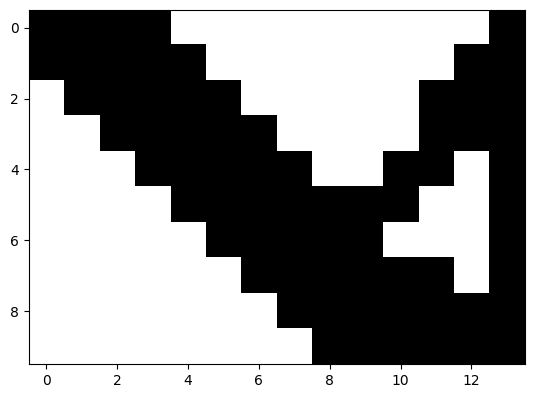

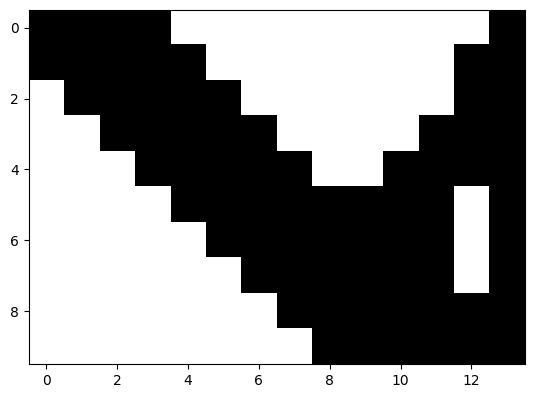

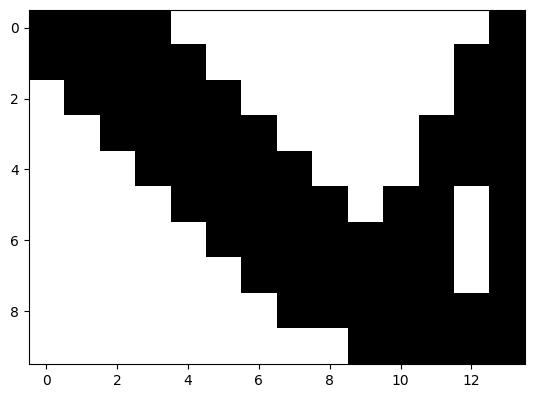

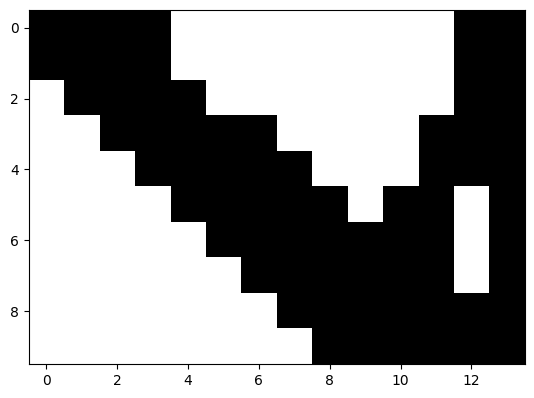

In [136]:
sc=1
mesh2 = RectangularGridMesher3D(ndim, nelx*sc, nely*sc, nelz*sc, elemSize, bcSettings)


xy2 = mesh2.generatePoints()
xy2 = torch.tensor(xy2, requires_grad = True).\
                                float().view(-1,3).to(device);
# fourierMap2=fourierMap
# fourierMap2['map'] = computeFourierMap(mesh2, fourierMap2).to(device);

if(fourierMap['isOn']):
  xyF2 = applyFourierMap(xy2, fourierMap)
else:
  xyF2 =xy2

rho = voxel_model.topNet(xyF2)

# Convert the log-space values to the densities/colors
# self.densities = self.log_densities
densities2 = rho.reshape(1, nelx*sc,nely*sc,nelz*sc)
densities2 = torch.sigmoid(densities2).cpu().detach().numpy()
D=densities2[0,:,:,:]
plotFieldOnMesh( np.swapaxes(D,1,2),iso=0.71)
DD=D
for i in range(D.shape[2]):
  # plt.imshow(1-DD[:,:,i],cmap="gray", interpolation='nearest',vmin=0.01, vmax=1)
  plt.imshow(1-DD[:,:,i],cmap="gray", interpolation='nearest')
  # plt.colorbar()
  plt.show()

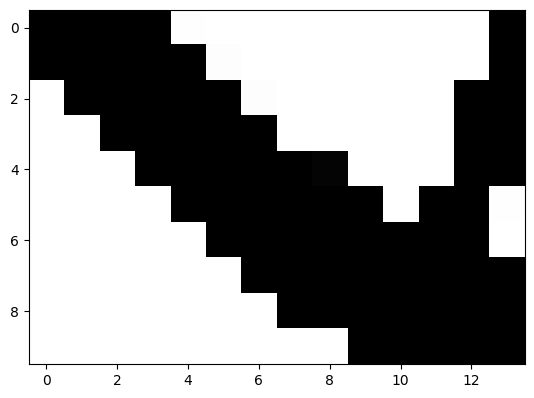

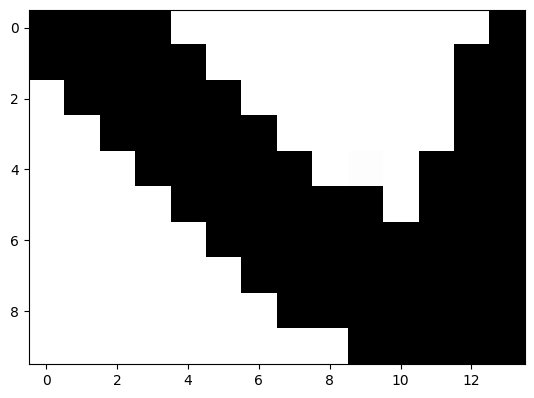

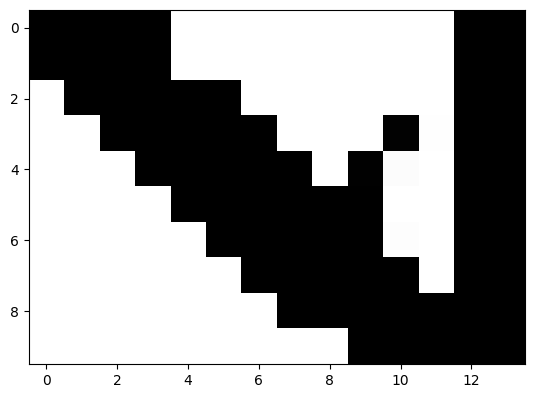

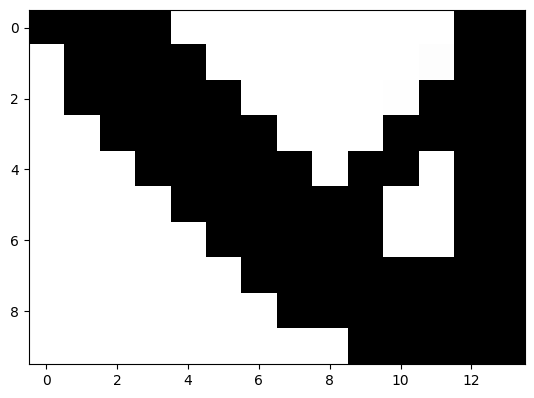

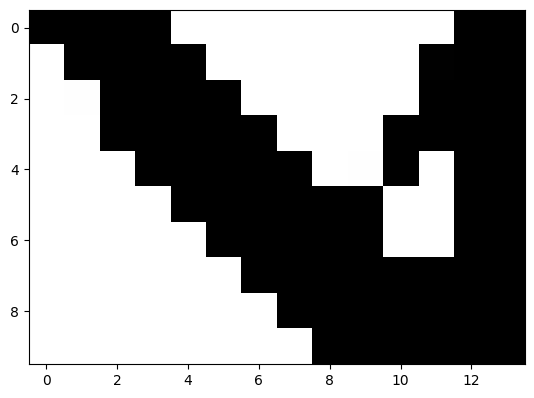

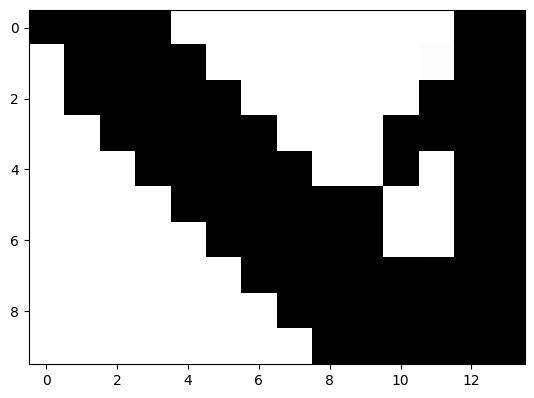

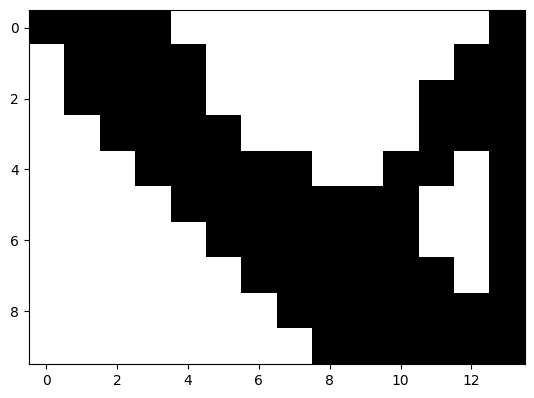

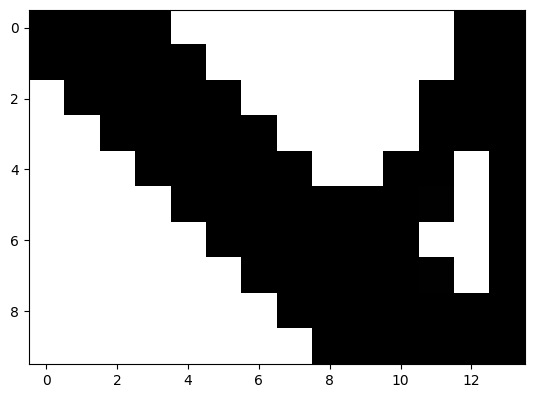

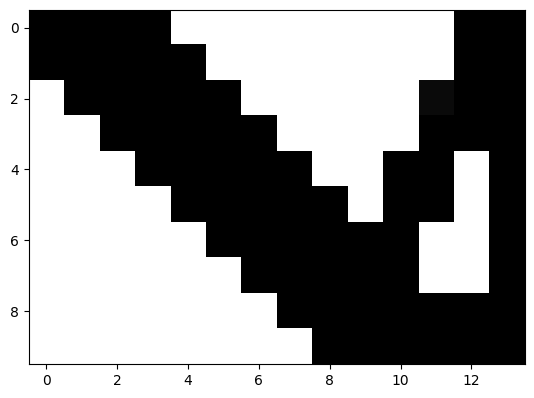

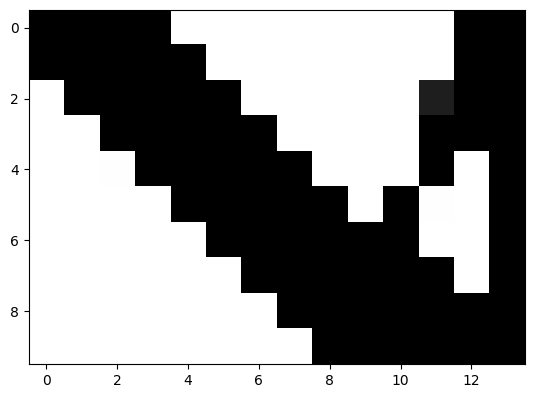

In [121]:
# plot results
densities = torch.sigmoid(voxel_model.densities).cpu().detach().numpy()
D=densities[0,:,:,:]
plotFieldOnMesh( np.swapaxes(D,1,2),iso=0.71)
DD=D
for i in range(D.shape[2]):
  # plt.imshow(1-DD[:,:,i],cmap="gray", interpolation='nearest',vmin=0.01, vmax=1)
  plt.imshow(1-DD[:,:,i],cmap="gray", interpolation='nearest')
  # plt.colorbar()
  plt.show()

In [ ]:
def getDOF3D(i,j,k,d,nelx,nely,nelz): #i,j,k from 0 to nelx,nely,nelz # d 0 x, 1 y , 2 z
  i=np.array(i).astype(int);j=np.array(j).astype(int);k=np.array(k).astype(int);
  dim=3
  el = j + (i * (nely+1)) + k * ((nelx+1)* (nely+1))
  return dim * el + d

In [ ]:
cube nelx=nelz=nely number of elements

number of nodes nelx+1*nelz+1*nely+1 ~= number of degrees of freeedom

In [ ]:

nelx=nelz=nely=1
i=1
j=0
k=1

# d 0 x, 1 y , 2 z
d=1
getDOF3D(i,j,k,d,nelx,nely,nelz)

19

## 5. Fit the volume



Here we carry out the volume fitting with differentiable rendering.

In order to fit the volume, we render it from the viewpoints of the `target_cameras`
and compare the resulting renders with the observed `target_images` and `target_silhouettes`.

The comparison is done by evaluating the mean huber (smooth-l1) error between corresponding
pairs of `target_images`/`rendered_images` and `target_silhouettes`/`rendered_silhouettes`.

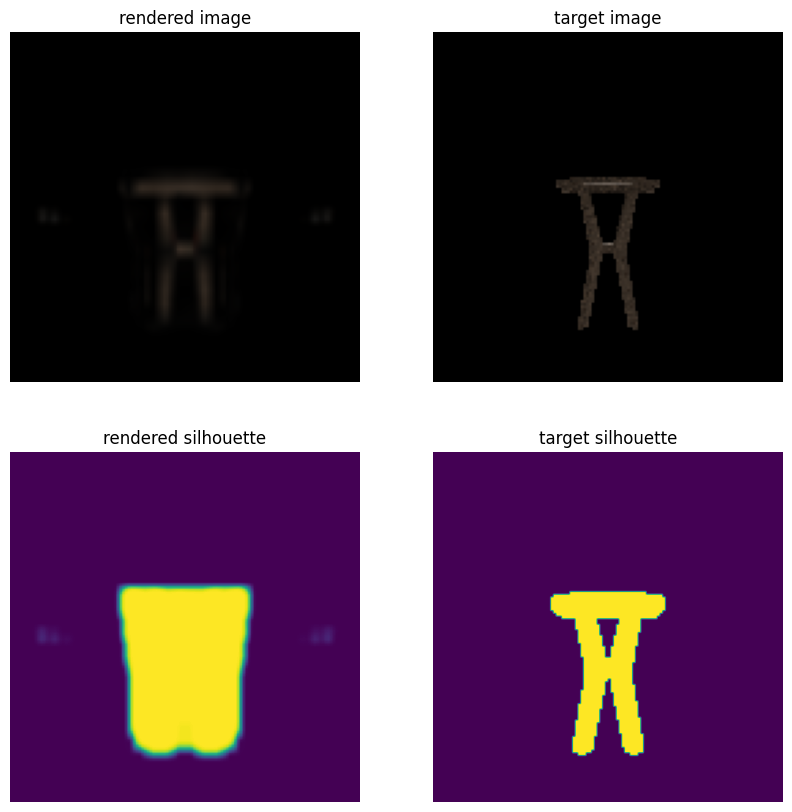

Iteration 00485: color_err = 3.02e-03 mask_err = 7.32e-02 FEA_err = 1.19e+00 J = 3.21e+03 vol = 5.77e-01
Iteration 00490: color_err = 3.01e-03 mask_err = 7.32e-02 FEA_err = 1.19e+00 J = 3.21e+03 vol = 5.77e-01
Iteration 00495: color_err = 3.01e-03 mask_err = 7.31e-02 FEA_err = 1.19e+00 J = 3.21e+03 vol = 5.77e-01


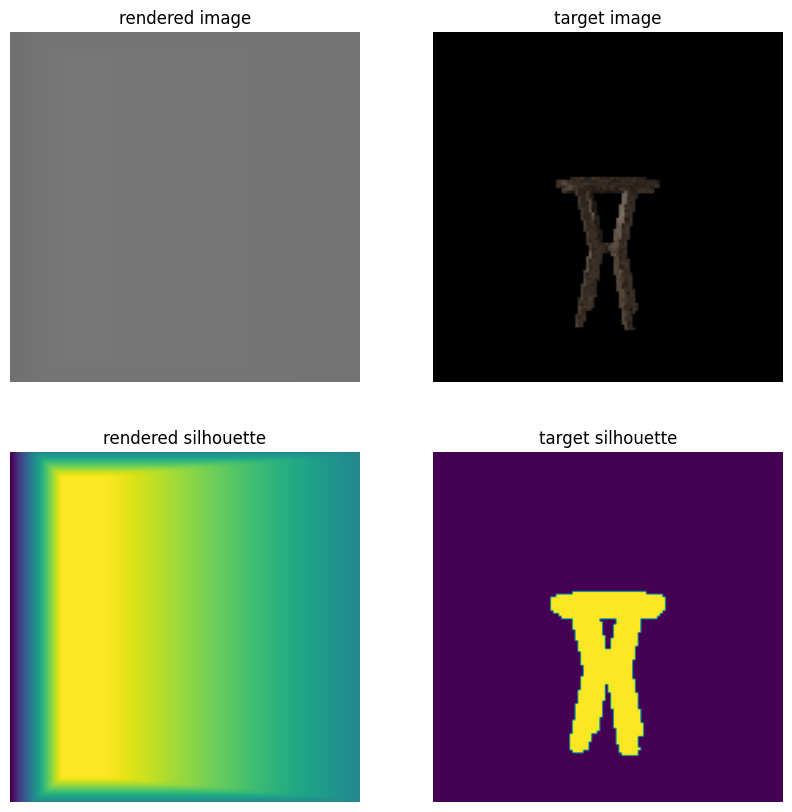

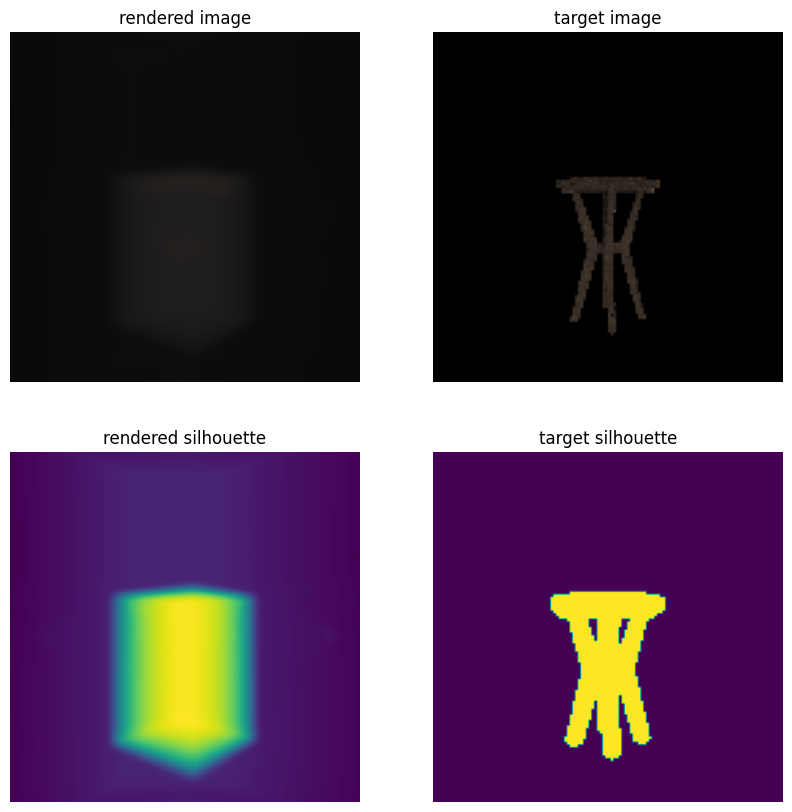

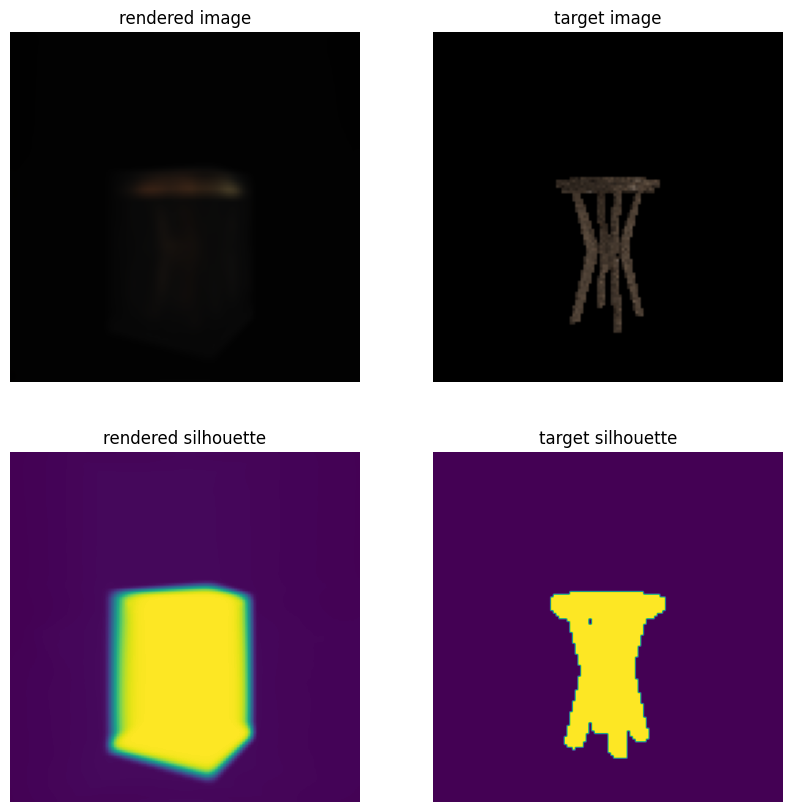

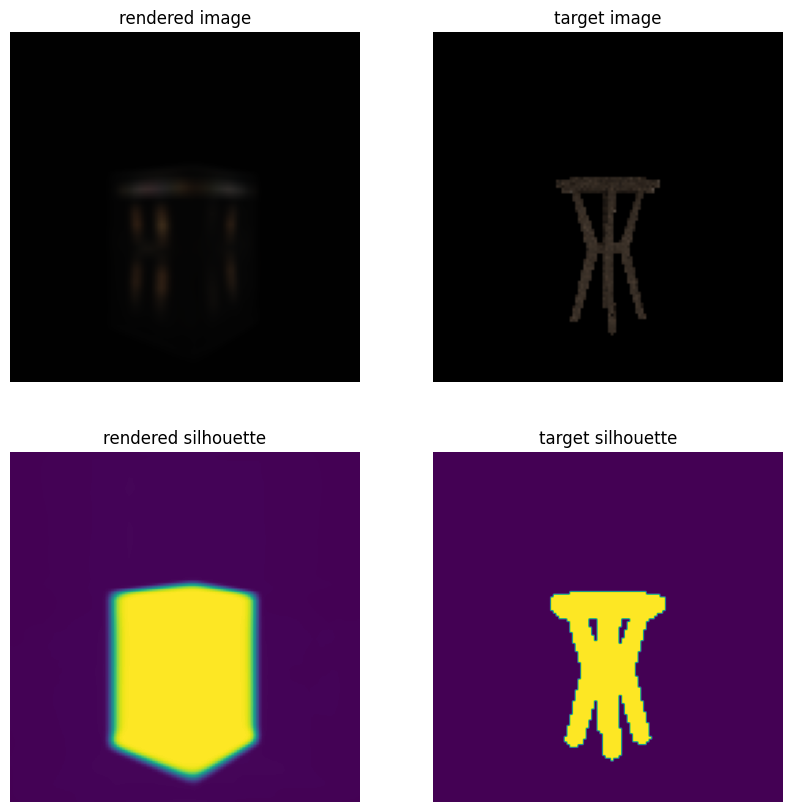

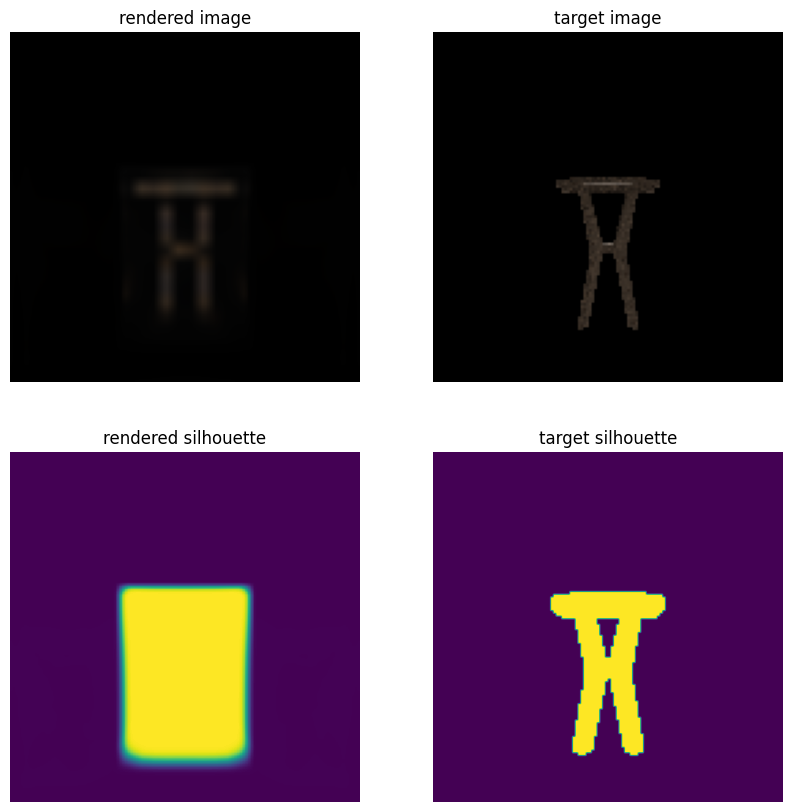

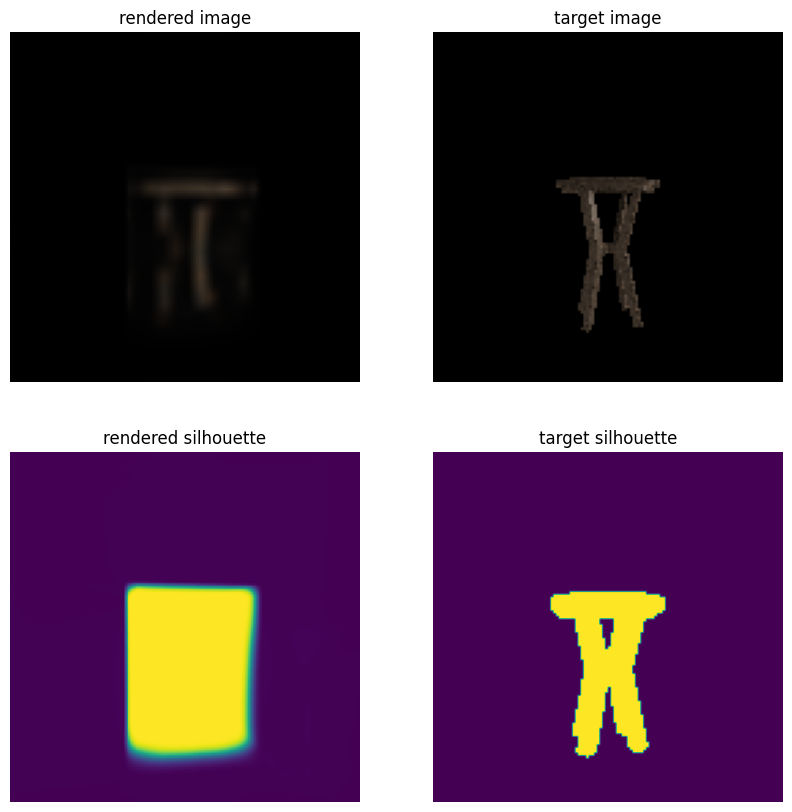

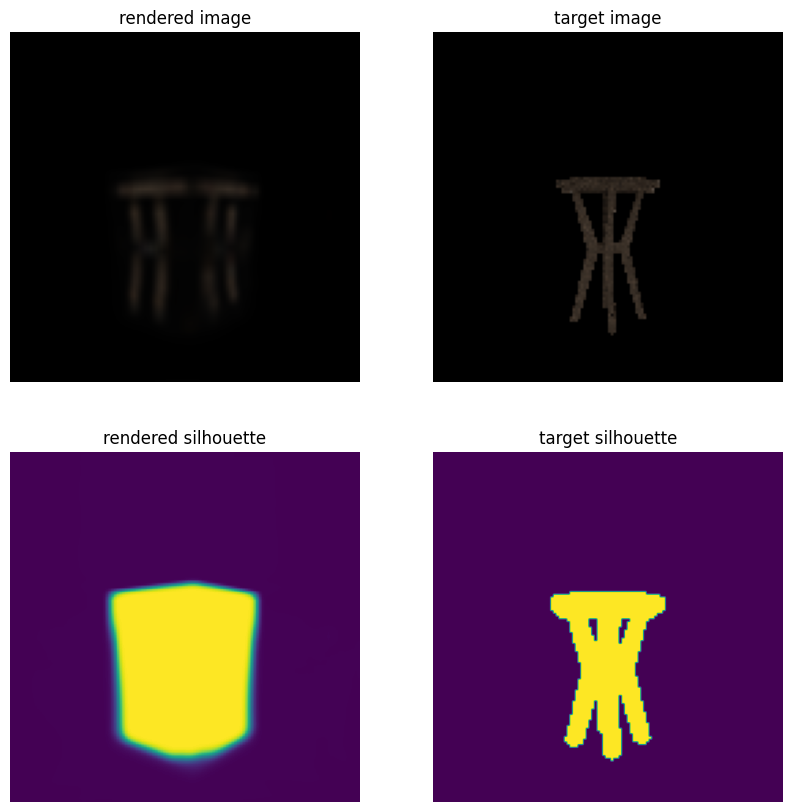

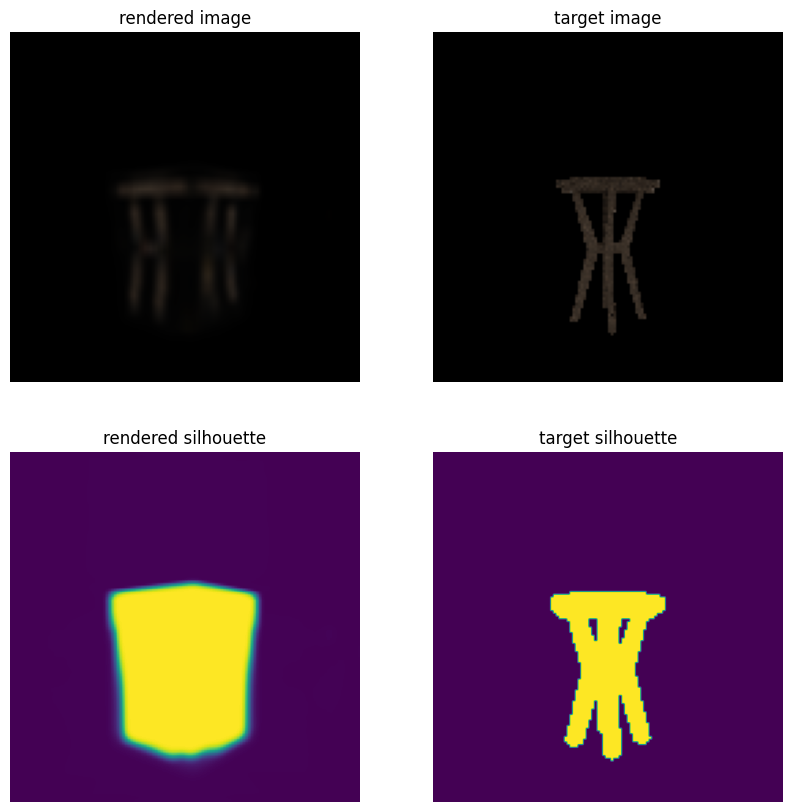

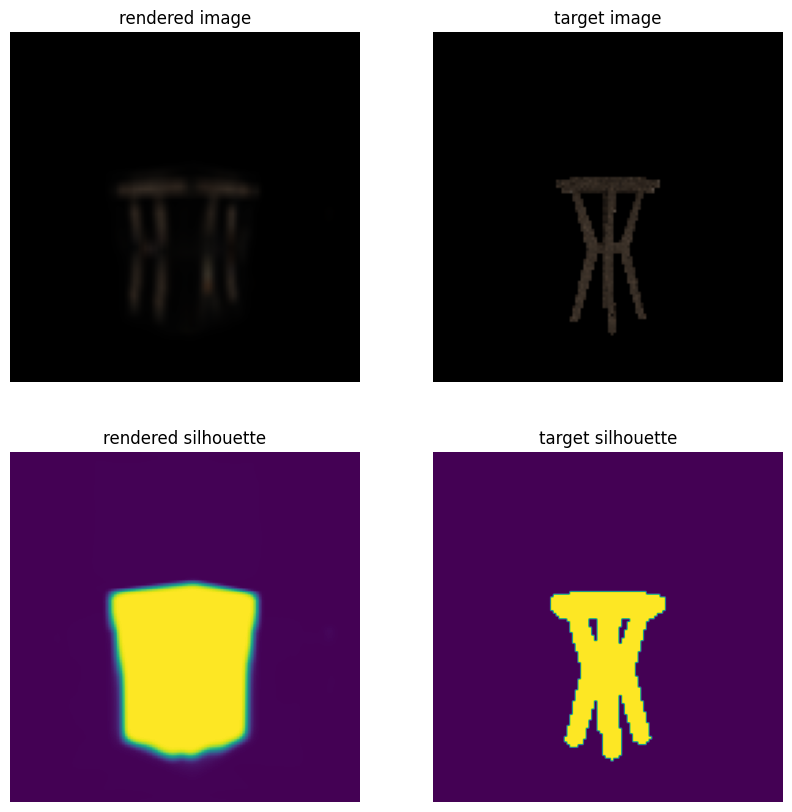

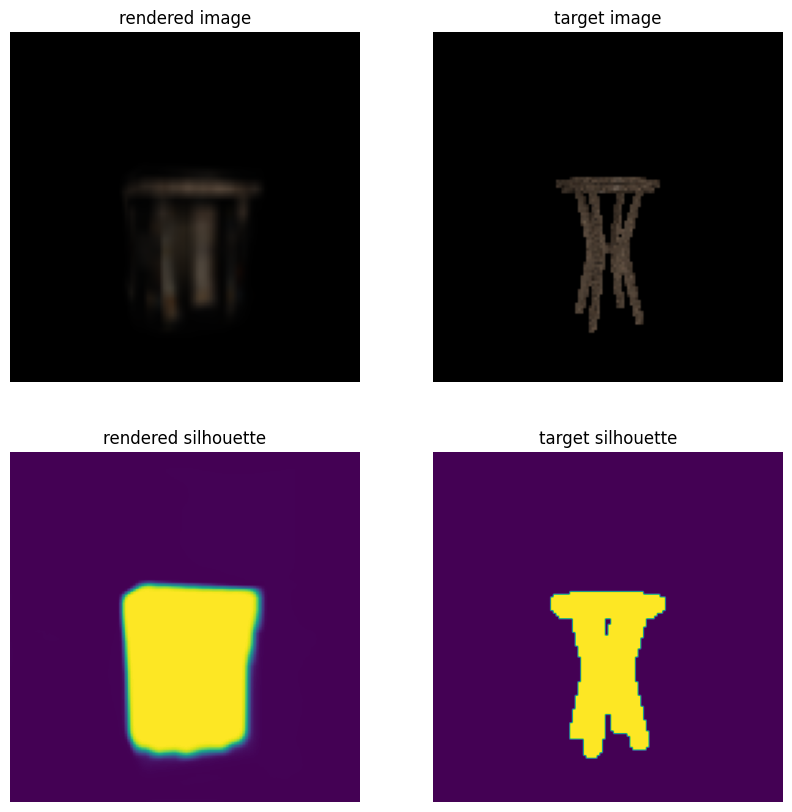

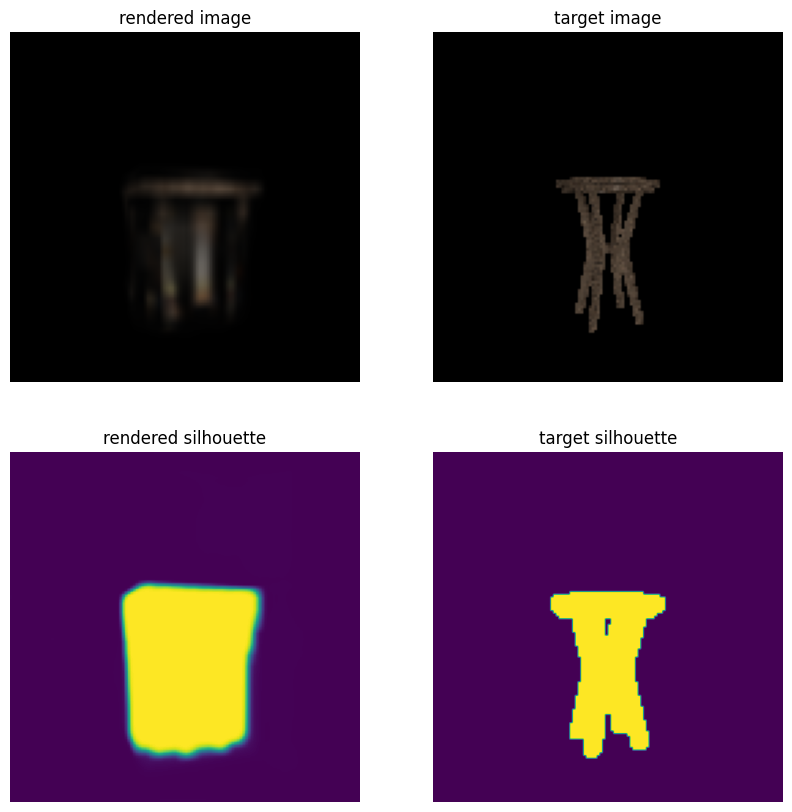

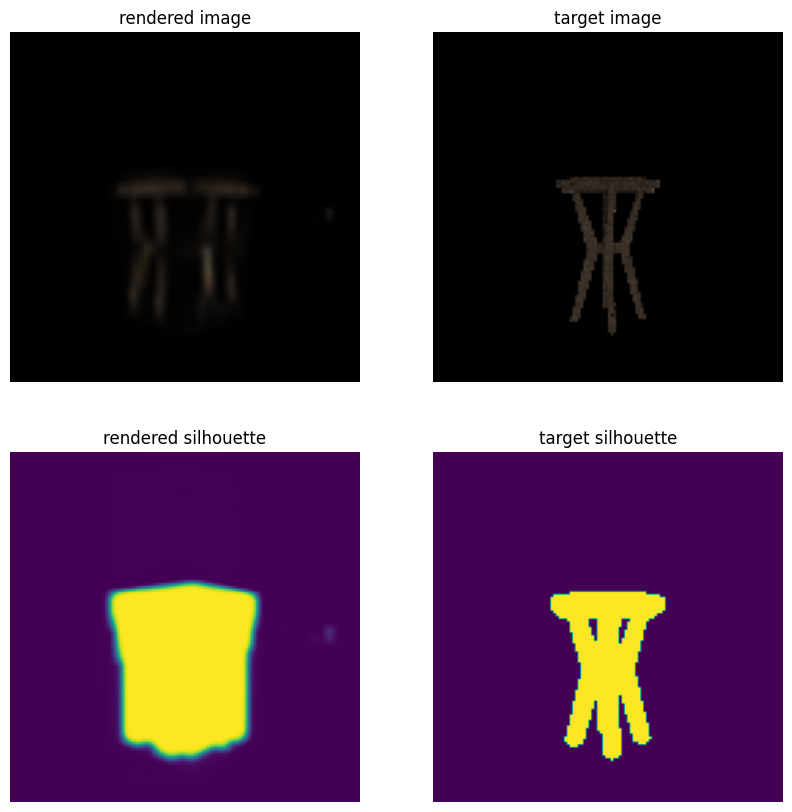

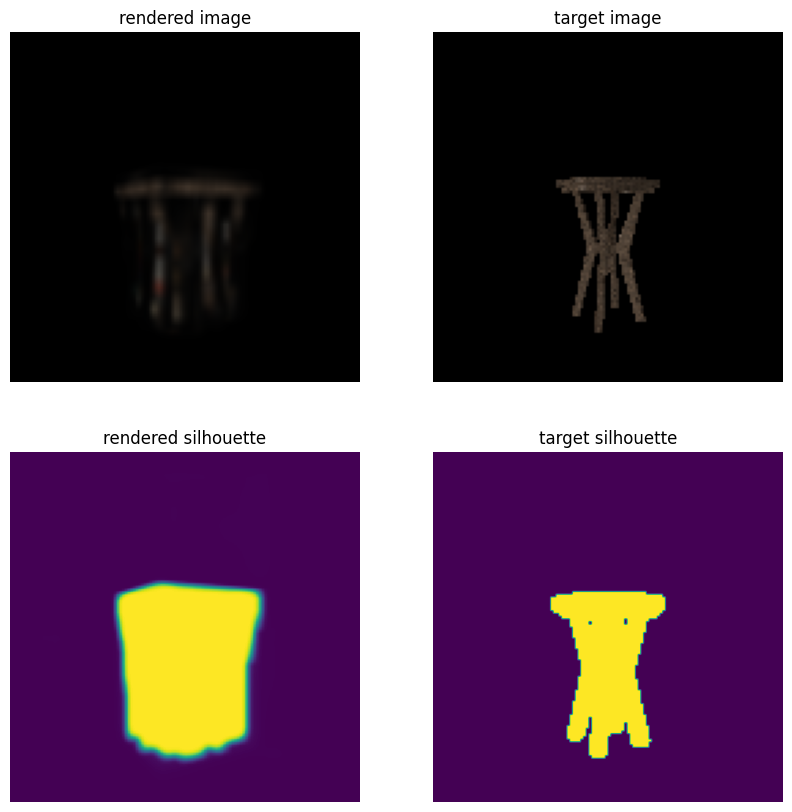

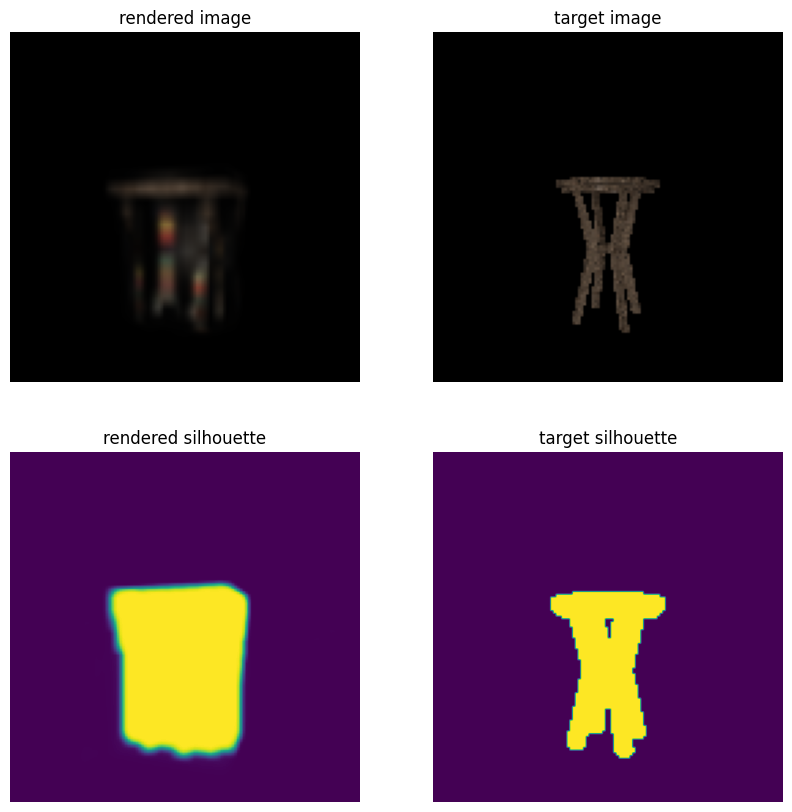

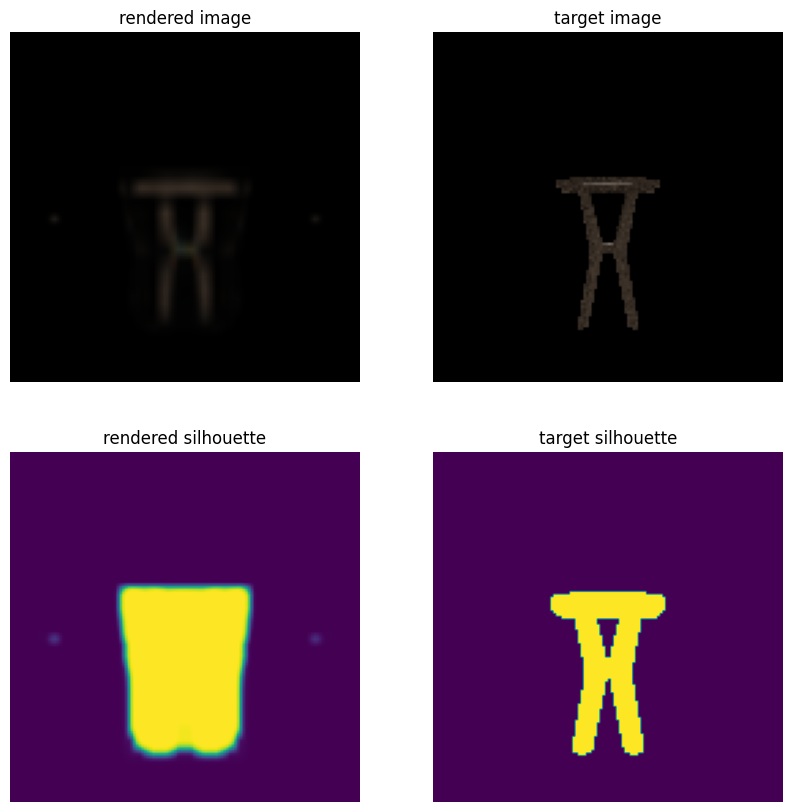

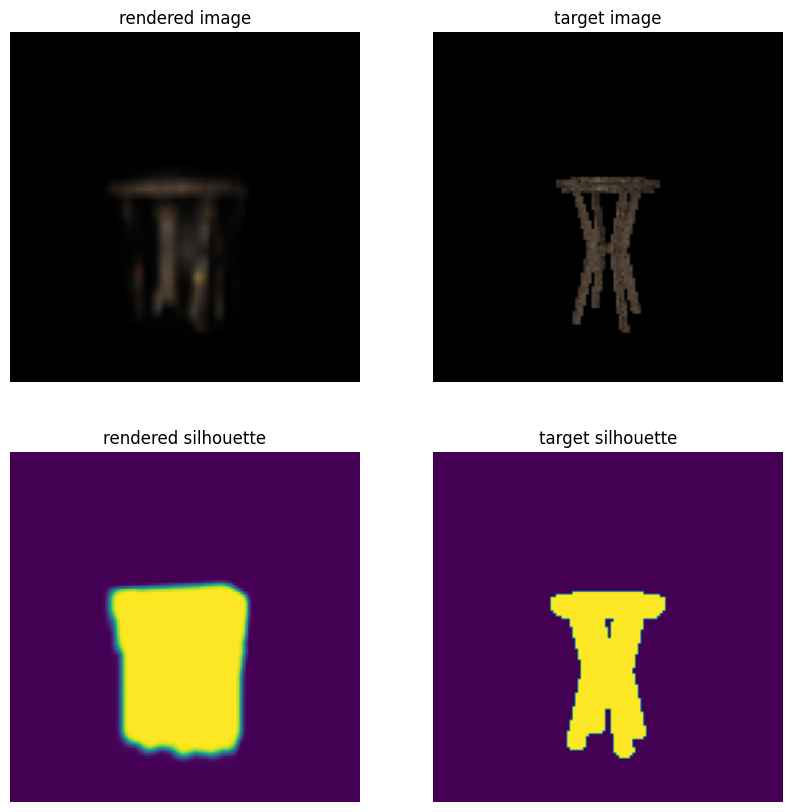

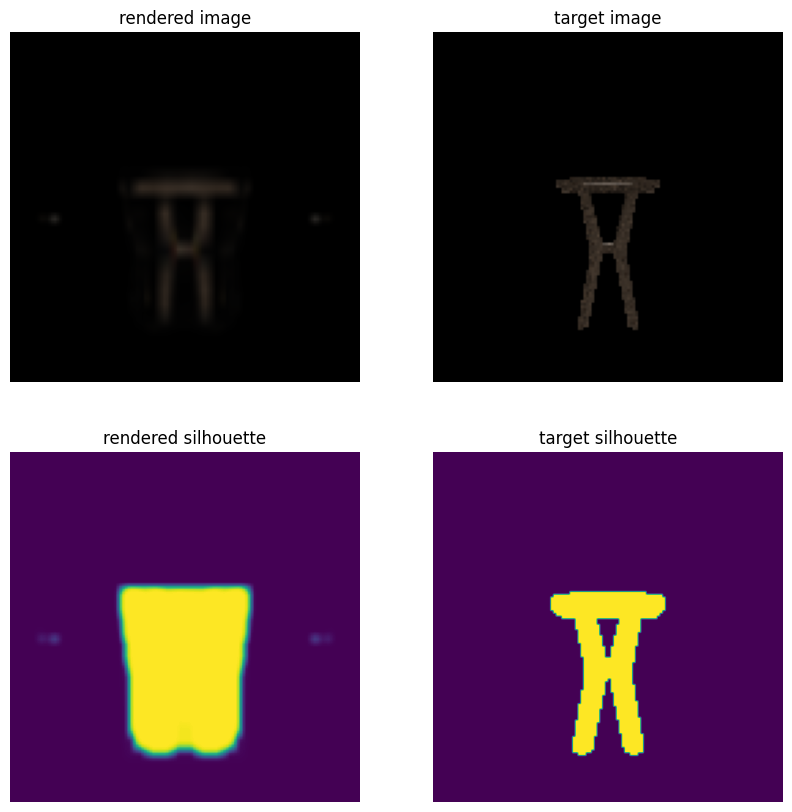

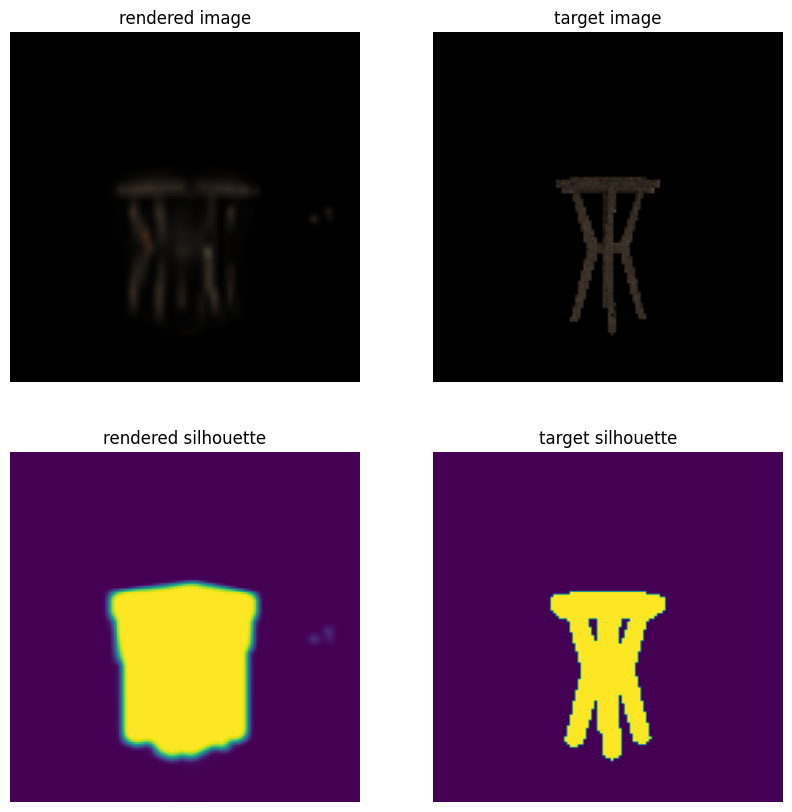

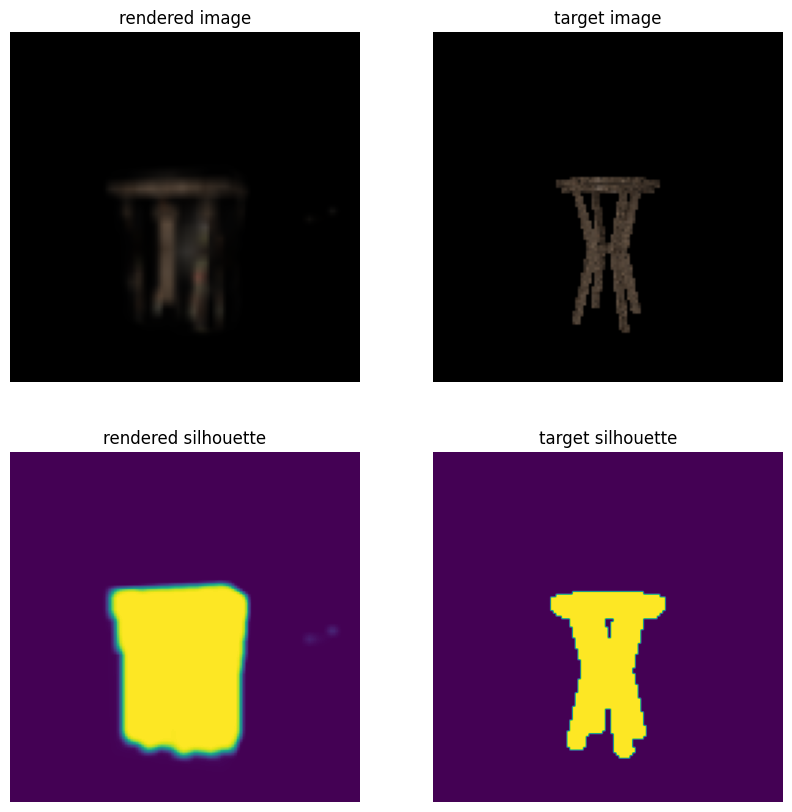

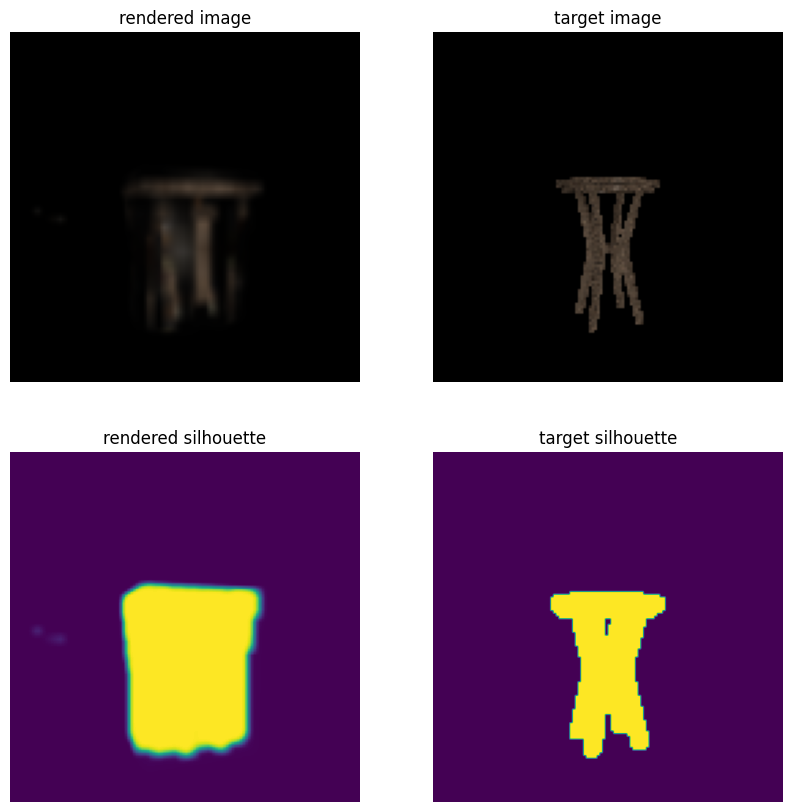

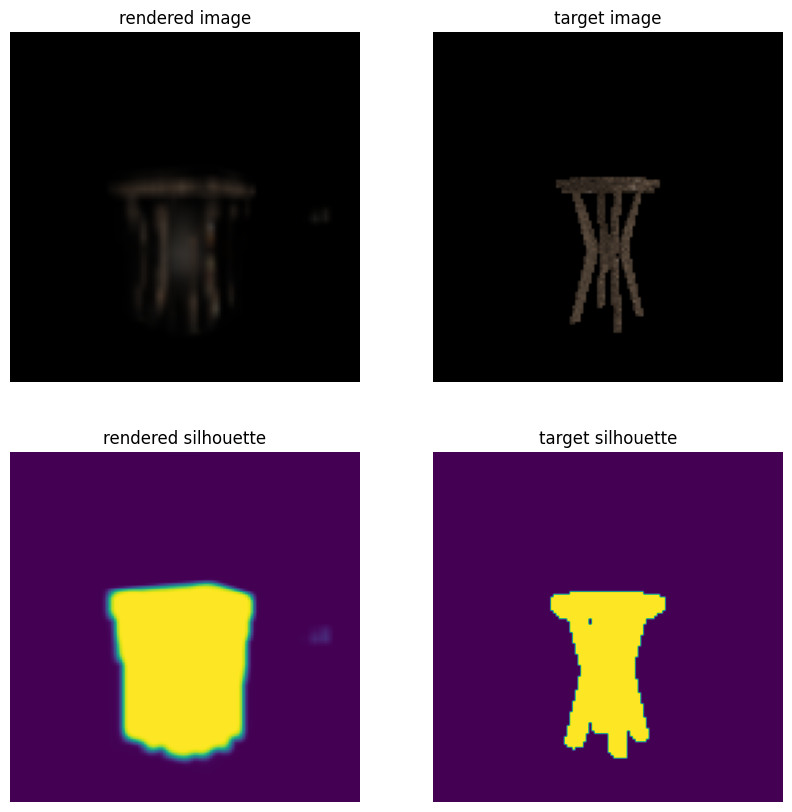

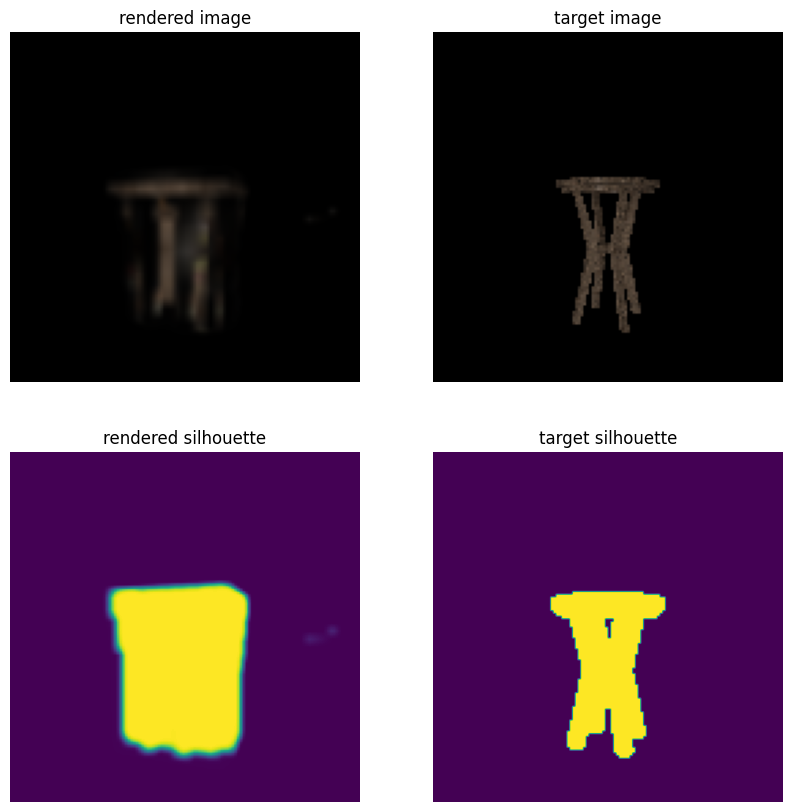

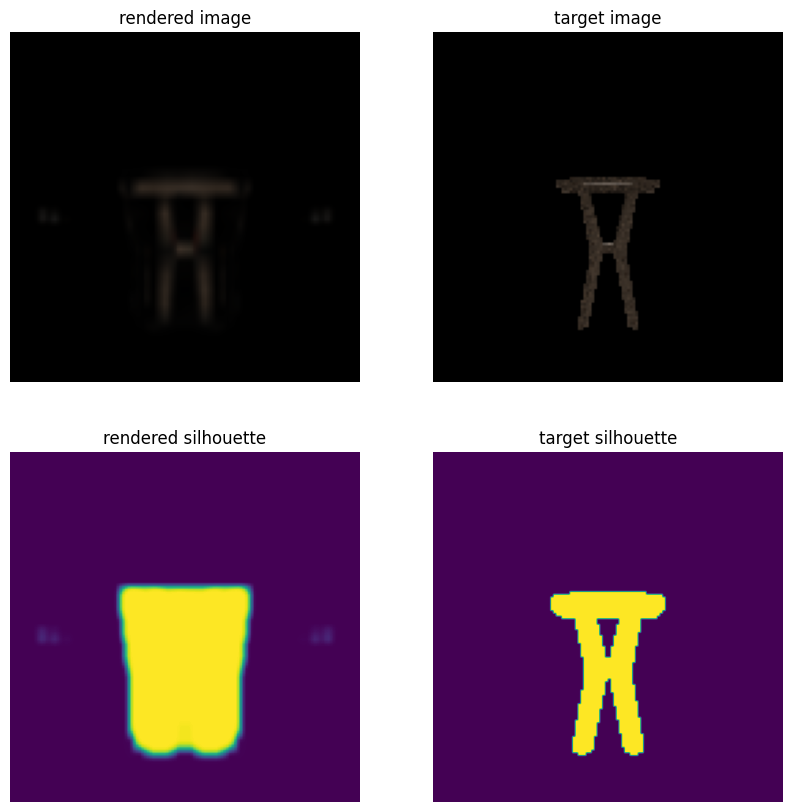

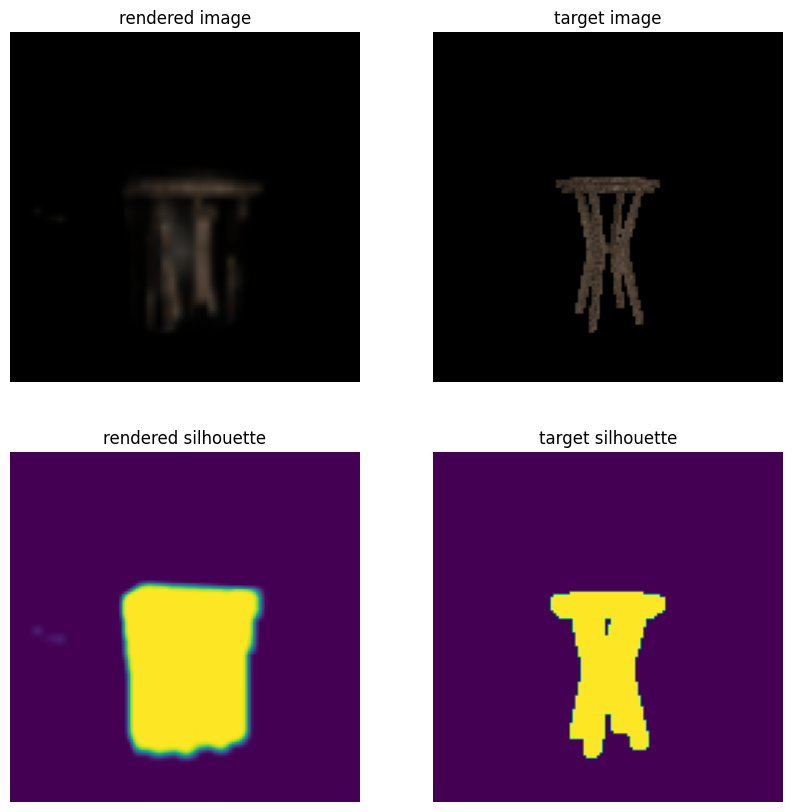

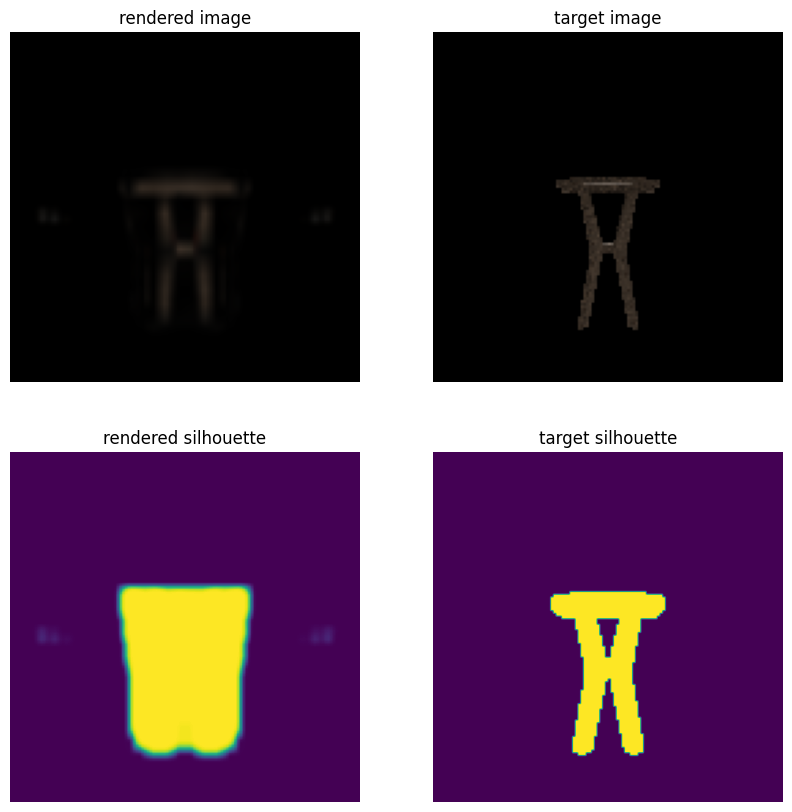

In [ ]:
# First move all relevant variables to the correct device.
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

# Instantiate the volumetric model.
# We use a cubical volume with the size of
# one side = 128. The size of each voxel of the volume
# is set to volume_extent_world / volume_size s.t. the
# volume represents the space enclosed in a 3D bounding box
# centered at (0, 0, 0) with the size of each side equal to 3.
volume_size = 128//2
volume_model = VolumeModel(
    renderer,
    volume_size=[volume_size] * 3,
    voxel_size = volume_extent_world / volume_size,
).to(device)

FEA_err_0=evaluateFEA(FEA,volume_model,1.0)
print(FEA_err_0)

FEA_err, J, vol=evaluateFEA(FEA,volume_model,1.0)
J0=J.item()

# Instantiate the Adam optimizer. We set its master learning rate to 0.1.
lr = 0.1
optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr)

# We do 300 Adam iterations and sample 10 random images in each minibatch.
batch_size = 10
n_iter = 500



for iteration in range(n_iter):

    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            volume_model.parameters(), lr=lr * 0.1
        )

    # Zero the optimizer gradient.
    optimizer.zero_grad()

    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx],
        T = target_cameras.T[batch_idx],
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )

    # Evaluate the volumetric model.
    rendered_images, rendered_silhouettes = volume_model(
        batch_cameras
    ).split([3, 1], dim=-1)

    # Compute the silhouette error as the mean huber
    # loss between the predicted masks and the
    # target silhouettes.
    sil_err = huber(
        rendered_silhouettes[..., 0], target_silhouettes[batch_idx],
    ).abs().mean()

    # Compute the color error as the mean huber
    # loss between the rendered colors and the
    # target ground truth images.
    color_err = huber(
        rendered_images, target_images[batch_idx],
    ).abs().mean()


    FEA_err=0
    FEA_err, J, vol=evaluateFEA(FEA,volume_model,J0)
    if iteration%50==0:
      J0=J.item()



    # The optimization loss is a simple
    # sum of the color and silhouette errors.
    loss = color_err + sil_err + FEA_err




    # Print the current values of the losses.
    if iteration % 5 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' color_err = {float(color_err):1.2e}'
            + f' mask_err = {float(sil_err):1.2e}'
            + f' FEA_err = {float(FEA_err):1.2e}'
            + f' J = {float(J):1.2e}'
            + f' vol = {float(vol):1.2e}'
        )

    # Take the optimization step.
    loss.backward()
    optimizer.step()

    # Visualize the renders every 40 iterations.
    if iteration % 20 == 0:
        # Visualize only a single randomly selected element of the batch.
        im_show_idx = int(torch.randint(low=0, high=batch_size, size=(1,)))
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.ravel()
        clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
        ax[0].imshow(clamp_and_detach(rendered_images[im_show_idx]))
        ax[1].imshow(clamp_and_detach(target_images[batch_idx[im_show_idx], ..., :3]))
        ax[2].imshow(clamp_and_detach(rendered_silhouettes[im_show_idx, ..., 0]))
        ax[3].imshow(clamp_and_detach(target_silhouettes[batch_idx[im_show_idx]]))
        for ax_, title_ in zip(
            ax,
            ("rendered image", "target image", "rendered silhouette", "target silhouette")
        ):
            ax_.grid("off")
            ax_.axis("off")
            ax_.set_title(title_)
        fig.canvas.draw(); fig.show()
        display.clear_output(wait=True)
        display.display(fig)

## 6. Visualizing the optimized volume



Finally, we visualize the optimized volume by rendering from multiple viewpoints that rotate around the volume's y-axis.

Generating rotating volume ...


  0%|          | 0/28 [00:00<?, ?it/s]

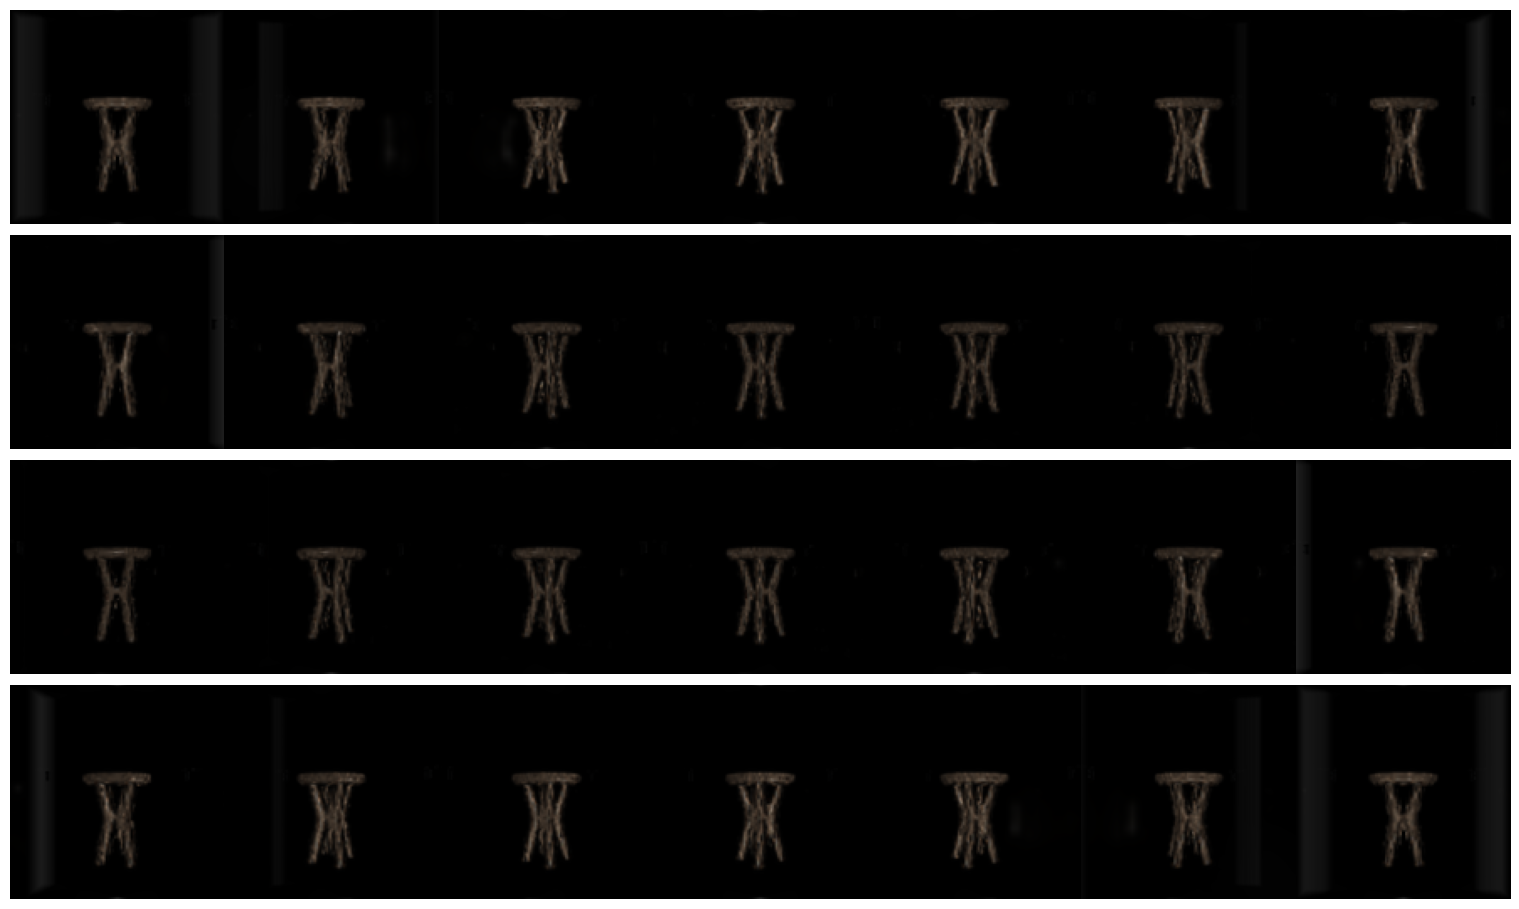

In [ ]:
def generate_rotating_volume(volume_model, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(0.0, 2.0 * 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Generating rotating volume ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear = target_cameras.znear[0],
            zfar = target_cameras.zfar[0],
            aspect_ratio = target_cameras.aspect_ratio[0],
            fov = target_cameras.fov[0],
            device=device,
        )
        frames.append(volume_model(camera)[..., :3].clamp(0.0, 1.0))
    return torch.cat(frames)

with torch.no_grad():
    rotating_volume_frames = generate_rotating_volume(volume_model, n_frames=7*4)

image_grid(rotating_volume_frames.clamp(0., 1.).cpu().numpy(), rows=4, cols=7, rgb=True, fill=True)
plt.show()

## 7. Visualize Density Field

In [ ]:
densities = torch.sigmoid(volume_model.log_densities).cpu().detach().numpy()

D=getVolumeChair(volume_model,scale=False).cpu().detach().numpy()
plotFieldOnMesh( np.swapaxes(densities[0,...],1,2))

plotFieldOnMesh( D)

In [ ]:
def getVolumeChair(volume_model,scale=False):
  densities = torch.sigmoid(volume_model.log_densities)
  # colors = torch.sigmoid(volume_model.log_colors).cpu().detach().numpy()

  if scale:
    densities=densities.unsqueeze(axis=0)
    scaleDown=2
    down=torch.nn.Upsample(size=(densities.shape[2]//scaleDown,
                                      densities.shape[3]//scaleDown,
                                      densities.shape[4]//scaleDown))
    densities=down(densities)
    densities=densities.squeeze(axis=0)

  r=10
  minn=densities.shape[1]//2-r
  maxx=densities.shape[1]//2+r
  r1=5
  minn1=densities.shape[1]//2-r1
  maxx1=densities.shape[1]//2+r1
  # D=densities[0,minn1:maxx1,minn:maxx,minn1:maxx1]
  D=densities[0,minn1:maxx1,21:35,minn1:maxx1]
  D=torch.transpose(torch.transpose(D, 0, 2),1,2)

  return D

D=getVolumeChair(volume_model,scale=False)
FEA.objectivePytorch(D.reshape(-1))

tensor(964523.2962, device='cuda:0', dtype=torch.float64,
       grad_fn=<DotBackward0>)

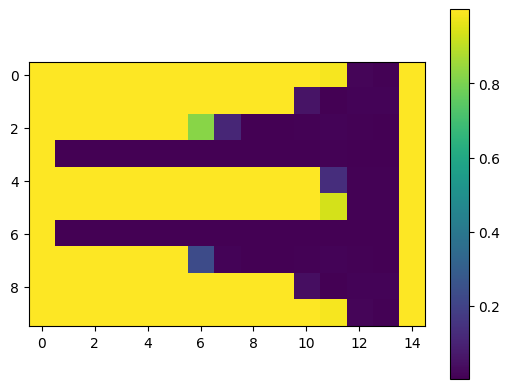

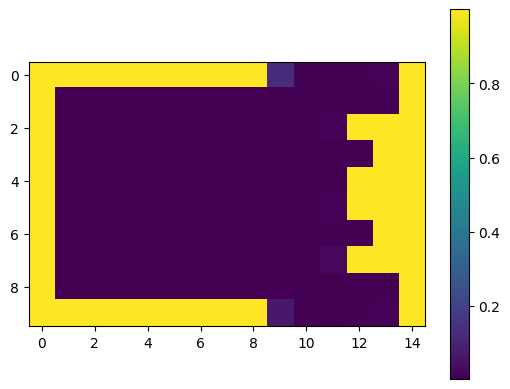

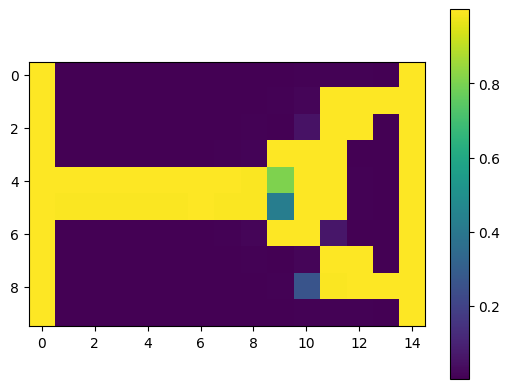

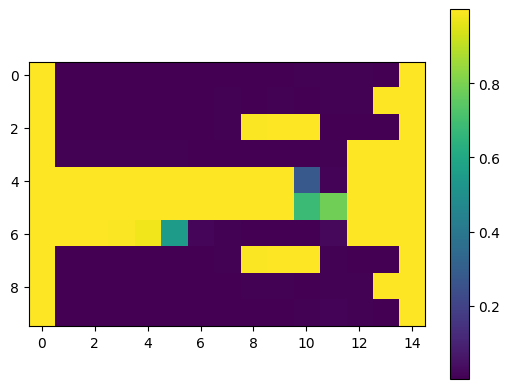

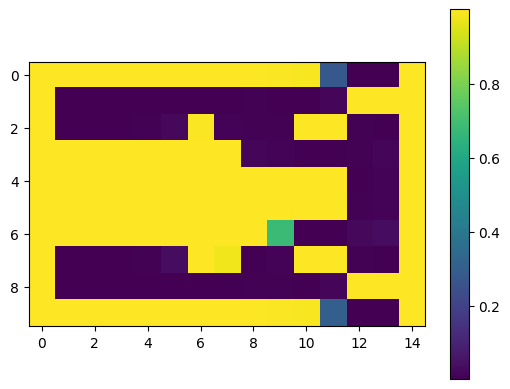

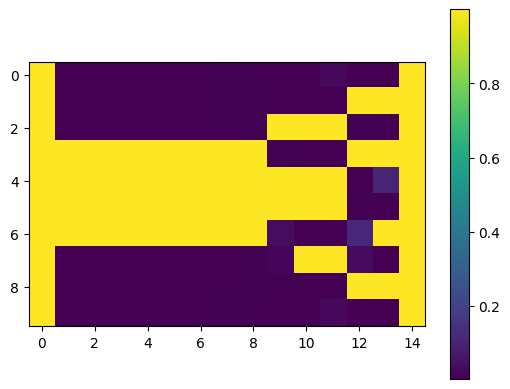

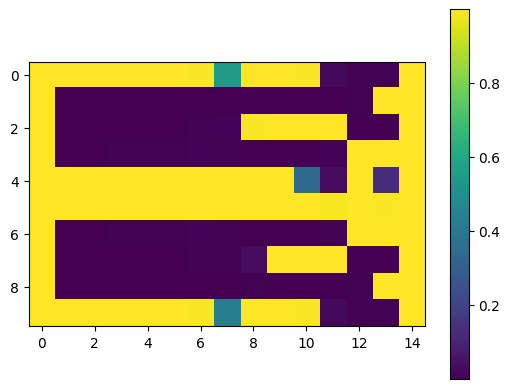

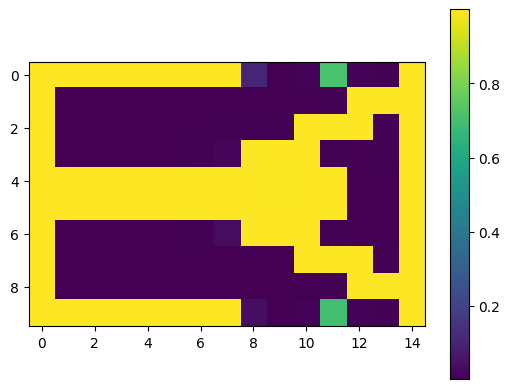

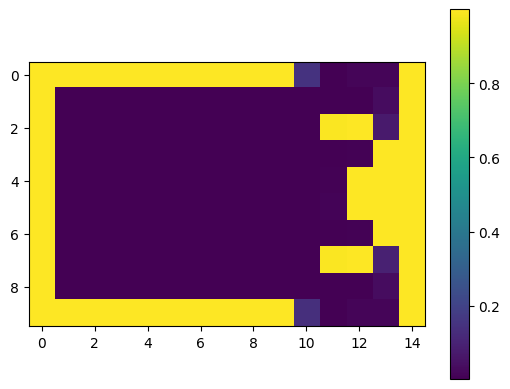

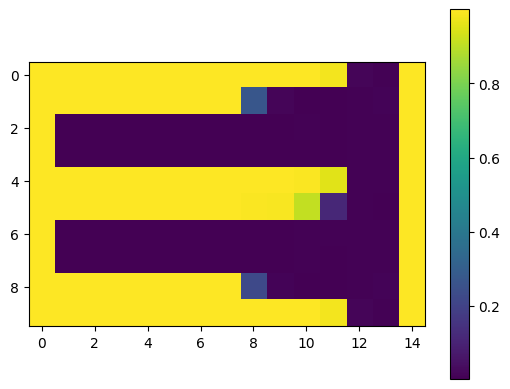

In [ ]:
densities = torch.sigmoid(volume_model.log_densities)
# colors = torch.sigmoid(volume_model.log_colors).cpu().detach().numpy()


r=10
minn=densities.shape[1]//2-r
maxx=densities.shape[1]//2+r
r1=5
minn1=densities.shape[1]//2-r1
maxx1=densities.shape[1]//2+r1
# D=densities[0,minn1:maxx1,minn:maxx,minn1:maxx1]
D=densities[0,minn1:maxx1,21:36,minn1:maxx1]
D=torch.transpose(torch.transpose(D, 0, 2),1,2)


DD=D.cpu().detach().numpy()
for i in range(D.shape[1]):
  plt.imshow(1-DD[:,i,:])
  plt.colorbar()
  plt.show()